In [455]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as ssp
import scipy.sparse.linalg as sla
import cvxpy as cp
n = 28 # number of timesteps
T = 50 # time will vary from 0 to T with step delt
delt = 0.5
N = int(n/delt)
ts = np.linspace(0,n,N+1)
gamma = .05 # damping, 0 is no damping

A = np.zeros((4,4))
B = np.zeros((4,2))
C = np.zeros((2,4))

A[0,0] = 1
A[1,1] = 1
A[0,2] = (1-gamma*delt/2)*delt
A[1,3] = (1-gamma*delt/2)*delt
A[2,2] = 1 - gamma*delt
A[3,3] = 1 - gamma*delt

B[0,0] = delt**2/2
B[1,1] = delt**2/2
B[2,0] = delt
B[3,1] = delt


In [478]:
# guidance command computation_convex
def  compute_guidance_cvx(state, desired_vec,angle_tol, N,delt):
    radian = angle_tol*np.pi/180
    r_des = state[1,:2]
    gamma = .05 # damping, 0 is no damping

    x = cp.Variable((2,N))
    r_pin = cp.Variable((2,N+1))
    v_pin = cp.Variable((2,N+1))
    
    mag = cp.norm(x,'fro')
    obj = cp.Minimize(mag)

    constr = [ 
        r_pin[:,0] == state[0,:2],
        v_pin[:,0] == state[0,2:],
        desired_vec@v_pin[:,-1] >= np.cos(radian)*np.linalg.norm(desired_vec)*cp.norm(v_pin[:,-1],2),
        v_pin[1,-1] <= -10,
        r_pin[:,-1] == r_des
        ]
    
    # 3축 최적 추력 명령 산출
    
    for t in range(N):
        constr += [        
            r_pin[:,t+1] == r_pin[:,t] + v_pin[:,t]*(1-gamma*delt/2)*delt,
            v_pin[:,t+1] == v_pin[:,t] + (1 - gamma*delt)*x[:,t],
            ]

    prob = cp.Problem(obj, constr)
    prob.solve(verbose=False,solver=cp.ECOS,reltol=1e-10)

    return x.value,r_pin.value,v_pin.value

In [479]:
def proj_onto_orthogonal_cone(u,v):
  norm_u = np.linalg.norm(u)
  norm_v = np.linalg.norm(v)
  
  if norm_u <= 1e-5 or norm_v <= 1e-5:
    return u,v

  cos_alpha = u@v/(norm_u*norm_v)
  cos_alpha = min(1,cos_alpha)
  cos_alpha = max(-1,cos_alpha)
  alpha = np.arccos(cos_alpha)
  theta = np.pi/2
  try:
    if  cos_alpha >= 1e-5:
      psi = np.arctan2( norm_v**2*np.sin(2*alpha),norm_u**2 - norm_v**2*np.cos(2*alpha) )
      phi = psi/2

      A = np.array([u,v])
      b1 = np.array([norm_u**2*np.cos(phi)**2,norm_u*norm_v*np.cos(phi)*np.cos(alpha+phi)])
      b2 = np.array([norm_u*norm_v*np.sin(phi)*np.sin(alpha+phi),norm_v**2*np.sin(alpha+phi)**2])

      u_update = np.linalg.solve(A,b1)
      v_update = np.linalg.solve(A,b2)
        
    elif cos_alpha <= -1e-5:
      K = alpha -theta
      psi = np.arctan2( norm_v**2*np.sin(2*K),(norm_u**2 + norm_v**2*np.cos(2*K)) )
      phi = psi/2

      A = np.array([u,v])
      b1 = np.array([norm_u**2*np.cos(phi)**2,norm_u*norm_v*np.cos(phi)*np.cos(alpha-phi)])
      b2 = np.array([norm_u*norm_v*np.cos(K-phi)*np.cos(theta+phi),norm_v**2*np.cos(K-phi)**2])

      u_update = np.linalg.solve(A,b1)
      v_update = np.linalg.solve(A,b2)

    else:
      u_update = u
      v_update = v
  
  except:
    u_update = u
    v_update = v
  return u_update, v_update

def proj_onto_desired_angle(v_f,desired_vec,angle_tol):
    v_f_update = v_f
    radian = angle_tol*np.pi/180
    theta = np.arccos(v_f.T@desired_vec/(np.linalg.norm(v_f)*np.linalg.norm(desired_vec)))
    
    if theta > radian and theta <= np.pi/2:
        v_f_update = desired_vec/np.linalg.norm(desired_vec)*np.linalg.norm(v_f)*np.cos(theta)
    elif theta > radian and theta > np.pi/2:
        v_f_update = -desired_vec/np.linalg.norm(desired_vec)*np.linalg.norm(v_f)*np.cos(theta)
    else:
        pass

    return v_f_update

In [480]:
x_0 = np.array([10, -20, 30, -10])
x_des = np.array([100, 50, -np.sqrt(31.622776601683793/2), -np.sqrt(31.622776601683793/2)])

G = np.zeros((4,2*N))
H = np.zeros((2,2*N))
H_all = np.zeros((2*N,2*N))
G_all = np.zeros((2*N,2*N))
rho = 1e10
b_0 = np.zeros((2*N))


for i in range(N):
  G[:, 2*i:2*(i+1)] = np.linalg.matrix_power(A,max(0,N-i-1))@B

H = G[2:,:]
G_r = G[:2,:]
for i in range(N-1):
  H_all[2*(i+1):2*(i+2),:2*(i+1)] = H[:,-2*(i+1):]
  
for i in range(N):
  b_0[2*i:2*(i+1)] = -(1 - gamma*delt)**i*x_0[2:]
b_f = -(1 - gamma*delt)**N*x_0[2:]

G_tilde = ssp.vstack((G_r,ssp.eye(2*N),H_all,H,ssp.eye(2*N)*np.sqrt(2/rho)))
G_tilde_square = G_tilde.T@G_tilde
G_tilde_inv = sla.inv(G_tilde_square)
G_init = ssp.vstack((G_r,ssp.eye(2*N)*np.sqrt(2/rho) ))

b = x_des - np.linalg.matrix_power(A,N)@x_0
b = b[:2]
b_tilde = np.hstack((b,np.zeros(2*N)))

x_opt = sla.lsqr(G_init,b_tilde)[0]

w_0 = np.zeros(2)
z_u = np.zeros((2*N))
w_u = np.zeros((2*N))
z_v = np.zeros(2*N)
w_v = np.zeros(2*N)
z_v_f = np.zeros(2)
w_v_f = np.zeros(2)

/usr/local/lib/python3.6/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:216: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


In [493]:
max_iter = 5000
desired_vec = np.array([2,-1])
angle_tol = 1

for i in range(max_iter):
    if i!=0:
        x_opt = G_tilde_inv@(G_r.T@(b-w_0) + (z_u - w_u) + H_all.T@( b_0 + z_v - w_v)+H.T@(b_f+z_v_f-w_v_f))    # x_opt update
##########################################################################################################################
  # z uodate
    z_u = x_opt + w_u
    z_v = H_all@x_opt - b_0 + w_v
    z_v_f = H@x_opt - b_f + w_v_f
    for t in range(N):
        z_u[2*t:2*(t+1)],z_v[2*t:2*(t+1)] = proj_onto_orthogonal_cone(z_u[2*t:2*(t+1)],z_v[2*t:2*(t+1)])
    z_v_f = proj_onto_desired_angle(z_v_f,desired_vec,angle_tol)
##########################################################################################################################
  # w update
    w_0 = w_0 + G_r@x_opt -b
    w_u = w_u + x_opt - z_u
    w_v = w_v + H_all@x_opt - b_0 - z_v
    w_v_f = w_v_f + H@x_opt - b_f - z_v_f
##########################################################################################################################

In [494]:
u_vec = x_opt
u_opt = u_vec.reshape(N,2).T

u_hat = sla.lsqr(G_r,b)[0]
u_opt_lsqr = u_hat.reshape(N,2).T

x = np.zeros((4,N+1))
x[:,0] = x_0

x_lsqr = np.zeros((4,N+1))
x_lsqr[:,0] = x_0

for t in range(N):
    x[:,t+1] = A.dot(x[:,t]) + B.dot(u_opt[:,t])

state = np.array([x_0,x_des])
u_opt_lsqr, x_lsqr[:2,:], x_lsqr[2:,:] = compute_guidance_cvx(state, desired_vec,angle_tol, N, delt)

Text(0, 0.5, '$y$ position')

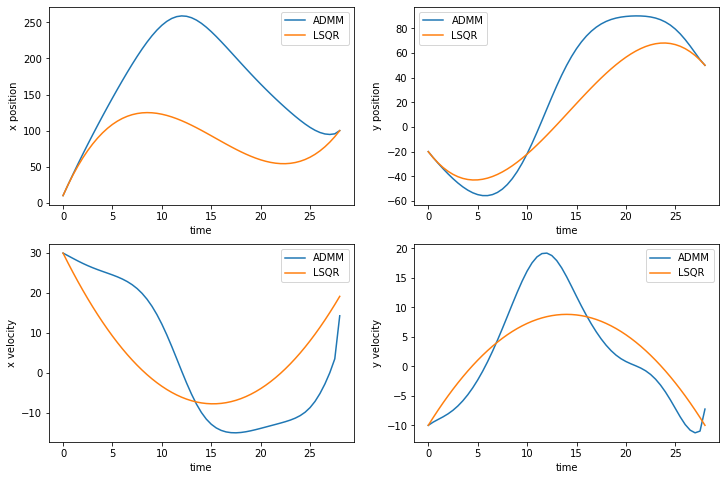

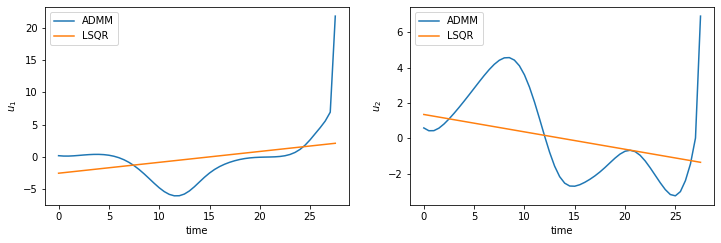

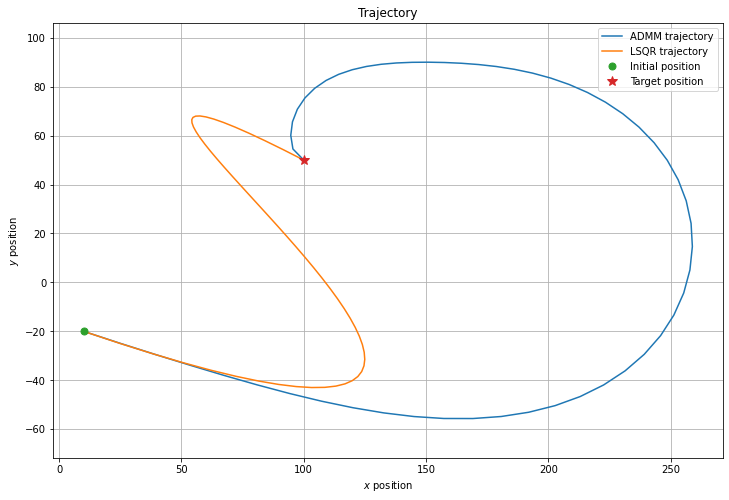

In [495]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(ts,x[0,:],label='ADMM')
plt.plot(ts,x_lsqr[0,:],label='LSQR')
plt.xlabel('time')
plt.ylabel('x position')
plt.legend()
plt.subplot(2,2,2)
plt.plot(ts,x[1,:],label='ADMM')
plt.plot(ts,x_lsqr[1,:],label='LSQR')
plt.xlabel('time')
plt.ylabel('y position')
plt.legend()
plt.subplot(2,2,3)
plt.plot(ts,x[2,:],label='ADMM')
plt.plot(ts,x_lsqr[2,:],label='LSQR')
plt.xlabel('time')
plt.ylabel('x velocity')
plt.legend()
plt.subplot(2,2,4)
plt.plot(ts,x[3,:],label='ADMM')
plt.plot(ts,x_lsqr[3,:],label='LSQR')
plt.xlabel('time')
plt.ylabel('y velocity')
plt.legend()

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(ts[:-1],u_opt[0,:],label='ADMM')
plt.plot(ts[:-1],u_opt_lsqr[0,:],label='LSQR')
plt.xlabel('time')
plt.ylabel(r'$u_1$')
plt.legend()
plt.subplot(2,2,2)
plt.plot(ts[:-1],u_opt[1,:],label='ADMM')
plt.plot(ts[:-1],u_opt_lsqr[1,:],label='LSQR')
plt.xlabel('time')
plt.ylabel(r'$u_2$')
plt.legend()

plt.figure(figsize=(12,8))
plt.plot(x[0,:],x[1,:], label='ADMM trajectory')
plt.plot(x_lsqr[0,:],x_lsqr[1,:], label='LSQR trajectory')
plt.plot(x_0[0], x_0[1], 'o', markersize=7, label='Initial position')
plt.plot(x_des[0], x_des[1], '*', markersize=10, label='Target position')
plt.title('Trajectory')
plt.legend()
plt.axis('equal')
plt.grid()
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')


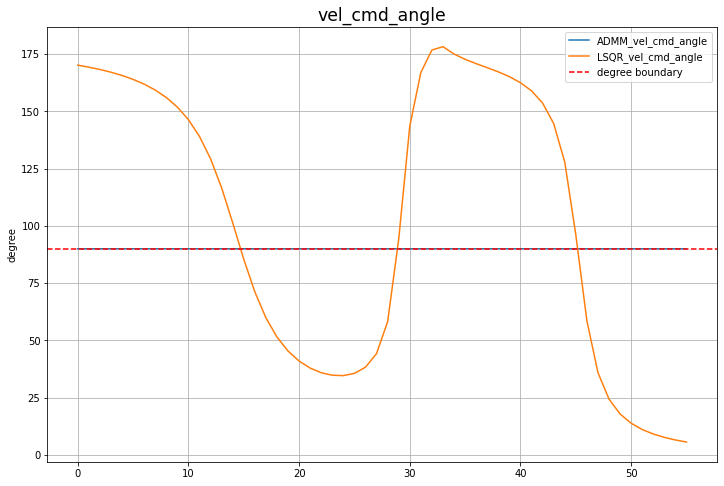

In [497]:
thrust = np.linalg.norm(u_opt,axis=0)
thrust_LSQR = np.linalg.norm(u_opt_lsqr,axis=0)

v_ADMM_for_angle = x[2:,:-1]
v_ADMM_mag = np.linalg.norm(v_ADMM_for_angle,axis=0)

inner_prod_v_u = np.sum((v_ADMM_for_angle*u_opt),axis=0)
radian_v_u = np.arccos(inner_prod_v_u/(v_ADMM_mag*thrust))

v_LSQR_for_angle = x_lsqr[2:,:-1]
v_LSQR_mag = np.linalg.norm(v_LSQR_for_angle,axis=0)

inner_prod_v_u_lsqr = np.sum((v_LSQR_for_angle*u_opt_lsqr),axis=0)
radian_v_u_lsqr = np.arccos(inner_prod_v_u_lsqr/(v_LSQR_mag*thrust_LSQR))

plt.figure(figsize=(12,8))
plt.plot(radian_v_u*180/np.pi,label='ADMM_vel_cmd_angle')
plt.plot(radian_v_u_lsqr*180/np.pi,label='LSQR_vel_cmd_angle')
plt.axhline(y=90, color='r', linestyle='--',label='degree boundary')
plt.ylabel('degree')
plt.title('vel_cmd_angle',fontsize='xx-large')
plt.grid()
plt.legend()